# Current Topics and Projects
## Analysis

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics


In [44]:
df_com = pd.read_csv('comments_final.csv')
df_vid = pd.read_csv('videos.csv')

In [45]:
df_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134883 entries, 0 to 134882
Data columns (total 35 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   commentID               134883 non-null  object 
 1   text                    134883 non-null  object 
 2   publishedAt             134883 non-null  object 
 3   authorID                134883 non-null  object 
 4   likeCount               134883 non-null  int64  
 5   totalReplyCount         134883 non-null  int64  
 6   parentID                134883 non-null  object 
 7   videoID                 134883 non-null  object 
 8   channelId               134883 non-null  object 
 9   username                134840 non-null  object 
 10  threat                  134882 non-null  float64
 11  toxicity                134882 non-null  float64
 12  identity_attack         134882 non-null  float64
 13  insult                  134882 non-null  float64
 14  severe_toxicity     

### Research Question 1: 
Do YouTube comments on German political YouTube accounts from the left, middle, and right exhibit significant differences in polarity and toxicity

In [46]:
df_vid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   videoPublishedAt      153 non-null    object 
 1   videolikeCount        153 non-null    int64  
 2   title                 153 non-null    object 
 3   description           153 non-null    object 
 4   viewCount             153 non-null    int64  
 5   likeCount             153 non-null    int64  
 6   commentCount          153 non-null    int64  
 7   videochannelId        153 non-null    object 
 8   videovideoID          153 non-null    object 
 9   channelName           153 non-null    object 
 10  transcript            153 non-null    object 
 11  sentiment_transcript  153 non-null    object 
 12  prob_pos_transcript   153 non-null    float64
 13  prob_neg_transcript   153 non-null    float64
 14  prob_neu_transcript   153 non-null    float64
dtypes: float64(3), int64(4)

In [47]:
print(df_com["stable"].describe())
print(df_com["stable_tox"].describe())
print(df_com["stable_sent"].describe())
print(df_com["in_cluster"].describe())

count    134883.000000
mean          0.142145
std           0.349201
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: stable, dtype: float64
count    134883.000000
mean          0.108123
std           0.310537
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: stable_tox, dtype: float64
count    134883.000000
mean          0.093941
std           0.291747
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: stable_sent, dtype: float64
count    134883.000000
mean          0.498995
std           0.500001
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: in_cluster, dtype: float64


In [48]:
# Three independent variabels: toxicity and structural balance (df_com) and prob_neg of transcript (df_vid)
# toxicity and structural balance needs to be grouped and aggregated by video
grouped_data = df_com.groupby('videoID')[['toxicity', 'stable_tox', 'in_cluster']].mean().reset_index()
grouped_data.rename(columns={'toxicity': 'toxicity_mean', 'videoID': 'videovideoID', 
                             'stable_tox': 'stable_tox_mean', 'in_cluster': 'in_cluster_mean'}, inplace=True)

# merge the variables with df_vid
df_vid = pd.merge(df_vid, grouped_data, on='videovideoID', how='left')


In [49]:
df_vid.head()

,videoPublishedAt,videolikeCount,title,description,viewCount,likeCount,commentCount,videochannelId,videovideoID,channelName,transcript,sentiment_transcript,prob_pos_transcript,prob_neg_transcript,prob_neu_transcript,toxicity_mean,stable_tox_mean,in_cluster_mean
0,2022-10-02T07:32:00Z,12884,Energie-Insider: Strom könnte 50 Prozent billi...,Das ist mal eine Analyse: „Die Energiekrise is...,121046,12884,1622,UCcoQ3WG2J_Xjwwyt-sJqh-w,RHsMs6KDgJI,"Achtung, Reichelt!",[Musik] herzlich willkommen bei 38 die Krise d...,neutral,0.004249,0.024490,0.971261,0.340678,0.188406,0.597308
1,2022-07-12T15:51:27Z,17664,JETZT OFFIZIELL: Habeck will Millionen Haushal...,Dramatische Pressekonferenz von Wirtschaftsmin...,225260,17664,3815,UCcoQ3WG2J_Xjwwyt-sJqh-w,QUJWYdu_EHk,"Achtung, Reichelt!",[Musik] [Applaus] [Musik] herzlich willkommen ...,neutral,0.002900,0.016498,0.980602,0.437257,0.067073,0.449426
2,2022-09-02T15:28:00Z,22243,Mit dieser Lüge bringt der WDR Frauen in höchs...,Vergangene Woche veröffentlichte der WDR eine ...,246589,22243,4006,UCcoQ3WG2J_Xjwwyt-sJqh-w,bppRqICEGX8,"Achtung, Reichelt!",ja [Musik] [Applaus] [Musik] herzlich willkomm...,neutral,0.004714,0.022497,0.972789,0.416470,0.103380,0.487365
3,2022-12-08T16:30:01Z,28015,Flüchtling ermordet Ece: Mütter warnten vor Be...,"Es ist gerade mal vier Tage her, dass ein Flüc...",404079,28015,6502,UCcoQ3WG2J_Xjwwyt-sJqh-w,c0G7qF44wLc,"Achtung, Reichelt!",dass ihr geschehen es hat nichts mit Politik z...,neutral,0.004097,0.030283,0.965620,0.498905,0.090319,0.459765
4,2022-12-04T08:26:00Z,17840,Hatespeech-Razzien: „Das sind totale Stasi-Vibes“,Die Fragen der Woche mit Eva Vlaardingerbroek!...,206101,17840,2635,UCcoQ3WG2J_Xjwwyt-sJqh-w,6P5Nlmw2xRE,"Achtung, Reichelt!",okay come on guys also es ist ganz klar das \n...,neutral,0.006579,0.039146,0.954274,0.408469,0.092092,0.519251


In [50]:
# Make Dummies out of dependent variable: take DW as middle category
channelId_dummy = pd.get_dummies(df_vid["channelName"])
df_vid = pd.concat([df_vid, channelId_dummy], axis = 1)
df_vid.head()

,videoPublishedAt,videolikeCount,title,description,viewCount,likeCount,commentCount,videochannelId,videovideoID,channelName,...,sentiment_transcript,prob_pos_transcript,prob_neg_transcript,prob_neu_transcript,toxicity_mean,stable_tox_mean,in_cluster_mean,"Achtung, Reichelt!",DW Deutsch,Jung & Naiv
0,2022-10-02T07:32:00Z,12884,Energie-Insider: Strom könnte 50 Prozent billi...,Das ist mal eine Analyse: „Die Energiekrise is...,121046,12884,1622,UCcoQ3WG2J_Xjwwyt-sJqh-w,RHsMs6KDgJI,"Achtung, Reichelt!",...,neutral,0.004249,0.024490,0.971261,0.340678,0.188406,0.597308,True,False,False
1,2022-07-12T15:51:27Z,17664,JETZT OFFIZIELL: Habeck will Millionen Haushal...,Dramatische Pressekonferenz von Wirtschaftsmin...,225260,17664,3815,UCcoQ3WG2J_Xjwwyt-sJqh-w,QUJWYdu_EHk,"Achtung, Reichelt!",...,neutral,0.002900,0.016498,0.980602,0.437257,0.067073,0.449426,True,False,False
2,2022-09-02T15:28:00Z,22243,Mit dieser Lüge bringt der WDR Frauen in höchs...,Vergangene Woche veröffentlichte der WDR eine ...,246589,22243,4006,UCcoQ3WG2J_Xjwwyt-sJqh-w,bppRqICEGX8,"Achtung, Reichelt!",...,neutral,0.004714,0.022497,0.972789,0.416470,0.103380,0.487365,True,False,False
3,2022-12-08T16:30:01Z,28015,Flüchtling ermordet Ece: Mütter warnten vor Be...,"Es ist gerade mal vier Tage her, dass ein Flüc...",404079,28015,6502,UCcoQ3WG2J_Xjwwyt-sJqh-w,c0G7qF44wLc,"Achtung, Reichelt!",...,neutral,0.004097,0.030283,0.965620,0.498905,0.090319,0.459765,True,False,False
4,2022-12-04T08:26:00Z,17840,Hatespeech-Razzien: „Das sind totale Stasi-Vibes“,Die Fragen der Woche mit Eva Vlaardingerbroek!...,206101,17840,2635,UCcoQ3WG2J_Xjwwyt-sJqh-w,6P5Nlmw2xRE,"Achtung, Reichelt!",...,neutral,0.006579,0.039146,0.954274,0.408469,0.092092,0.519251,True,False,False


In [51]:
# prepare variabels for model
X = df_vid[["toxicity_mean", "prob_neg_transcript", "stable_tox_mean"]]
y = df_vid[['Jung & Naiv', 'DW Deutsch', 'Achtung, Reichelt!']]
print(X)
print(y)

     toxicity_mean  prob_neg_transcript  stable_tox_mean
0         0.340678             0.024490         0.188406
1         0.437257             0.016498         0.067073
2         0.416470             0.022497         0.103380
3         0.498905             0.030283         0.090319
4         0.408469             0.039146         0.092092
..             ...                  ...              ...
148       0.223647             0.021504         0.126437
149       0.261161             0.011883         0.178571
150       0.259582             0.020863         0.089286
151       0.222358             0.027436         0.108108
152       0.303147             0.018321         0.176471

[153 rows x 3 columns]
     Jung & Naiv  DW Deutsch  Achtung, Reichelt!
0          False       False                True
1          False       False                True
2          False       False                True
3          False       False                True
4          False       False                Tru

In [52]:
# check for missing values
missing_values = X.isnull().sum()
print(missing_values)

# replace NA with mean
column_means = X.mean()
X = X.fillna(column_means)
print(X)

toxicity_mean          0
prob_neg_transcript    0
stable_tox_mean        0
dtype: int64
     toxicity_mean  prob_neg_transcript  stable_tox_mean
0         0.340678             0.024490         0.188406
1         0.437257             0.016498         0.067073
2         0.416470             0.022497         0.103380
3         0.498905             0.030283         0.090319
4         0.408469             0.039146         0.092092
..             ...                  ...              ...
148       0.223647             0.021504         0.126437
149       0.261161             0.011883         0.178571
150       0.259582             0.020863         0.089286
151       0.222358             0.027436         0.108108
152       0.303147             0.018321         0.176471

[153 rows x 3 columns]


In [53]:
# Fit regression
def fit_regression(X,y):
    ''' 
    function to fit regresssion for three dummy variables as dependent variable of logistic regression
    '''

    # Split in test and train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    log_model = LogisticRegression()
    log_model.fit(X_train, y_train)

    # make prediction
    y_pred = log_model.predict(X_test)

    # get accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # report
    classification_rep = metrics.classification_report(y_test, y_pred, output_dict=True)

    # Statsmodel provides p-value for hypothesis test
    # Add constant term to the predictor matrix (intercept)
    X_train_const = sm.add_constant(X_train)

    # Fit logistic regression model using statsmodels
    model_sm = sm.MNLogit(y_train, X_train_const)
    result = model_sm.fit()

    # calculate Odds
    odds = result.params
    
    return y_pred, accuracy, classification_rep, result, odds

In [54]:
channel_names = ['Jung & Naiv', 'DW Deutsch', 'Achtung, Reichelt!']
for channel in channel_names:
    # call function
    y_pred, accuracy, classification_rep, result, odds_table = fit_regression(X,y[channel])

    # print accuracy and classification report
    print("Accuracy:", accuracy)
    classification_rep_df = pd.DataFrame(classification_rep).transpose()
    print(classification_rep_df.to_latex(index=False, float_format="{:.1f}".format))

    # print result table in latex format
    # Print summary statistics
    print(result.summary().as_latex())

    print("Odds:", odds_table.to_latex(float_format="{:.3f}".format))

C:\Users\Raphaela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Raphaela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Raphaela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificatio

Optimization terminated successfully.
         Current function value: 0.316530
         Iterations 7
Accuracy: 0.6956521739130435
\begin{tabular}{rrrr}
\toprule
precision & recall & f1-score & support \\
\midrule
0.7 & 1.0 & 0.8 & 32.0 \\
0.0 & 0.0 & 0.0 & 14.0 \\
0.7 & 0.7 & 0.7 & 0.7 \\
0.3 & 0.5 & 0.4 & 46.0 \\
0.5 & 0.7 & 0.6 & 46.0 \\
\bottomrule
\end{tabular}

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}        &   Jung \& Naiv   & \textbf{  No. Observations:  } &      107    \\
\textbf{Model:}                &     MNLogit      & \textbf{  Df Residuals:      } &      103    \\
\textbf{Method:}               &       MLE        & \textbf{  Df Model:          } &        3    \\
\textbf{Date:}                 & Sun, 27 Aug 2023 & \textbf{  Pseudo R-squ.:     } &   0.5091    \\
\textbf{Time:}                 &     18:39:45     & \textbf{  Log-Likelihood:    } &   -33.869   \\
\textbf{converged:}            &       True       & \textbf{  LL-Null:           } &

C:\Users\Raphaela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Raphaela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Raphaela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificatio

### Check conditions for logistic regression

In [55]:
# 1. Linearity of Log-Odds
# sm.graphics.plot_partregress_grid(result)

# 2. Independence of Observations: assumed

# 3. No Multicollinearity: almost no correlation between independent variables
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.to_latex(index=False, float_format="{:.1f}".format))

cov_matrix = result.cov_params()
print(cov_matrix.to_latex(index=False, float_format="{:.1f}".format))

correlation_matrix = X.corr()
print(correlation_matrix.to_latex())

# 4. Large Sample Size: reasonable sample size of 149170
print(X.describe().to_latex())

# 5. No Outliers: no unusual patterns or outliers

# 6. No Perfect Separation: independent variable has low variance

\begin{tabular}{lr}
\toprule
feature & VIF \\
\midrule
toxicity_mean & 4.8 \\
prob_neg_transcript & 1.3 \\
stable_tox_mean & 4.3 \\
\bottomrule
\end{tabular}

\begin{tabular}{rrrr}
\toprule
\multicolumn{4}{r}{1} \\
const & toxicity_mean & prob_neg_transcript & stable_tox_mean \\
\midrule
4.5 & -9.9 & -0.1 & -4.1 \\
-9.9 & 24.4 & -0.1 & 2.9 \\
-0.1 & -0.1 & 1.1 & 0.1 \\
-4.1 & 2.9 & 0.1 & 24.2 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & toxicity_mean & prob_neg_transcript & stable_tox_mean \\
\midrule
toxicity_mean & 1.000000 & 0.216647 & -0.128439 \\
prob_neg_transcript & 0.216647 & 1.000000 & -0.064327 \\
stable_tox_mean & -0.128439 & -0.064327 & 1.000000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & toxicity_mean & prob_neg_transcript & stable_tox_mean \\
\midrule
count & 153.000000 & 153.000000 & 153.000000 \\
mean & 0.359148 & 0.102240 & 0.125371 \\
std & 0.075860 & 0.206582 & 0.058916 \\
min & 0.132493 & 0.006049 & 0.000000 \\
25% & 0.297135 &

### Research Question 2: 
What are the underlying factors that contribute to the polarity and toxicity of YouTube comments on German political YouTube accounts from the left, middle, and right?

In [56]:
df_com['personal_attack'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 134883 entries, 0 to 134882
Series name: personal_attack
Non-Null Count   Dtype
--------------   -----
134883 non-null  int64
dtypes: int64(1)
memory usage: 1.0 MB


In [57]:
# replace empty lists of personal_attack variables with NA
df_com = df_com.replace({"personal_attack_name": "[]", "personal_attack_gender": "[]", "personal_attack_party": "[]"}, np.nan)
df_com.replace("0", 0, inplace=True)
df_com.head()

,commentID,text,publishedAt,authorID,likeCount,totalReplyCount,parentID,videoID,channelId,username,...,user_replies,cluster_values,cluster,stable_tox,stable_sent,personal_attack,personal_attack_name,personal_attack_gender,personal_attack_party,in_cluster
0,UgzNbjRq-bmbAkT8AKd4AaABAg,Die Kraftwerke weiterlaufen zu lassen ist nich...,2023-05-11T19:37:05Z,UCffvix1CZh19OHEKNd5HlaQ,0,0,0,RHsMs6KDgJI,UCcoQ3WG2J_Xjwwyt-sJqh-w,Dana Schlegel,...,1,[0.4245987745633333],0.424599,0,0,0,NaN,NaN,NaN,1
1,UgzLliIQM1p-mszsMJJ4AaABAg,Bitte alle kompetenten Fachleute in die Politi...,2023-03-11T11:12:50Z,UCO7NBsrEO1VlEgpjsqlODKg,0,0,0,RHsMs6KDgJI,UCcoQ3WG2J_Xjwwyt-sJqh-w,Marti,...,3,"[0.39610165102813855, 0.30893602838888884]",0.352519,0,0,0,NaN,NaN,NaN,1
2,UgyQnUE08i_MhHHR-5R4AaABAg,Ich stimme grundsätzlich zu! Die Politik könnt...,2023-02-28T12:59:18Z,UCJ_FNG2X8he2dDal7Co689A,0,0,0,RHsMs6KDgJI,UCcoQ3WG2J_Xjwwyt-sJqh-w,Thomas Bracht,...,10,[0.4192263335261031],0.419226,0,0,0,NaN,NaN,NaN,1
3,UgzmCbLPz_GiXJicg0l4AaABAg,Zitat Dieter Nuhr: die Grünen sind dabei Deuts...,2023-02-21T10:23:51Z,UCnv0JgIk9UAYsvktFdSUsiA,0,0,0,RHsMs6KDgJI,UCcoQ3WG2J_Xjwwyt-sJqh-w,Gixxer NRW Germany,...,8,"[0.4487647916384181, 0.46313270040322574]",0.455949,0,0,0,NaN,NaN,NaN,1
4,UgzqdmnqOOpQkXzJ0uB4AaABAg,Angebot und Nachfrage. Ein wirtschaftlicher Gr...,2022-12-30T16:21:33Z,UCYs8otO1f01y2_Fif5_Y5PQ,0,0,0,RHsMs6KDgJI,UCcoQ3WG2J_Xjwwyt-sJqh-w,Lisanne Benz,...,1,[0.3678198210992997],0.367820,0,0,0,NaN,NaN,NaN,1


In [59]:
print(df_com['totalReplyCount'].describe())

count    134883.000000
mean          0.514342
std           3.516488
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         260.000000
Name: totalReplyCount, dtype: float64


In [60]:
# define variables
X = df_com[['prob_neg',  'identity_attack', 'personal_attack']]
y = df_com["totalReplyCount"]

In [61]:
# check for missing values
missing_values = X.isnull().sum()
print(missing_values)

column_means = X.mean()
X = X.fillna(column_means)
print(X.describe())

prob_neg           0
identity_attack    1
personal_attack    0
dtype: int64
            prob_neg  identity_attack  personal_attack
count  134883.000000     1.348830e+05    134883.000000
mean        0.418578     3.949268e-01         0.099471
std         0.452481     2.710023e-01         0.299295
min         0.000004     5.141927e-08         0.000000
25%         0.005772     1.581286e-01         0.000000
50%         0.074081     3.377392e-01         0.000000
75%         0.964480     6.040796e-01         0.000000
max         0.999740     1.000000e+00         1.000000


In [62]:
# fit linear regression
model = sm.OLS(y, X)
result_linear = model.fit()
print(result_linear.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    & totalReplyCount  & \textbf{  R-squared (uncentered):}      &       0.012     \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared (uncentered):} &       0.012     \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       }          &       530.8     \\
\textbf{Date:}             & Sun, 27 Aug 2023 & \textbf{  Prob (F-statistic):}          &       0.00      \\
\textbf{Time:}             &     18:40:55     & \textbf{  Log-Likelihood:    }          &  -3.6164e+05    \\
\textbf{No. Observations:} &      134883      & \textbf{  AIC:               }          &   7.233e+05     \\
\textbf{Df Residuals:}     &      134880      & \textbf{  BIC:               }          &   7.233e+05     \\
\textbf{Df Model:}         &           3      & \textbf{                     }          &                 \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     }    

### Check conditions for linear regression

In [63]:
# configure font 
plt.rcParams["font.family"] = "Times New Roman"

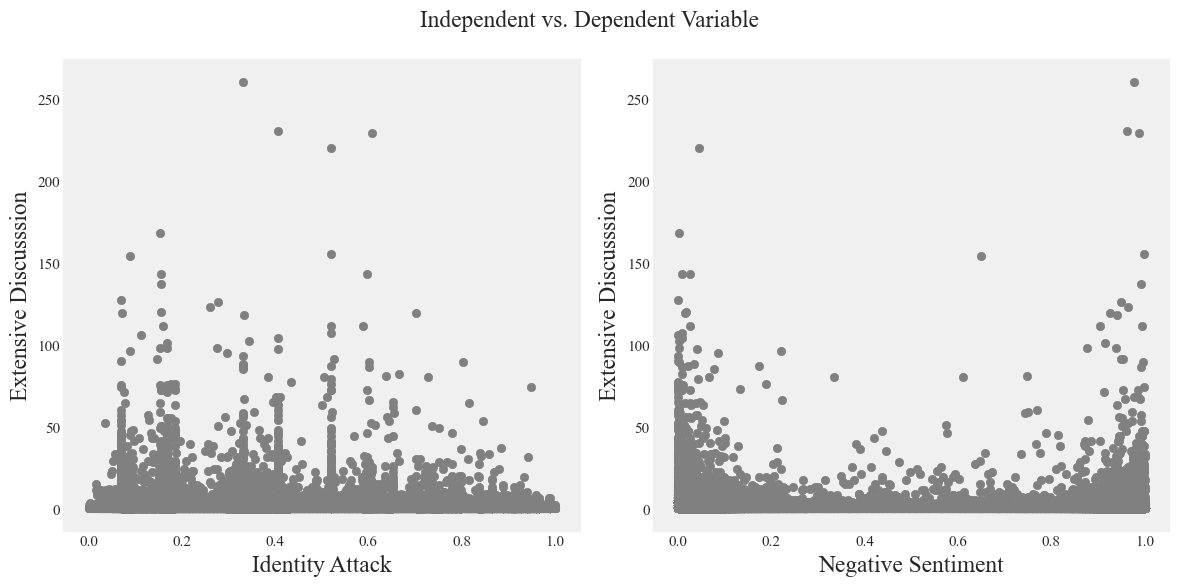

\begin{tabular}{lr}
\toprule
feature & VIF \\
\midrule
prob_neg & 1.7 \\
identity_attack & 1.8 \\
personal_attack & 1.1 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & prob_neg & identity_attack & personal_attack \\
\midrule
prob_neg & 1.000000 & 0.217969 & 0.006826 \\
identity_attack & 0.217969 & 1.000000 & 0.032564 \\
personal_attack & 0.006826 & 0.032564 & 1.000000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & prob_neg & identity_attack & personal_attack \\
\midrule
count & 134883.000000 & 134883.000000 & 134883.000000 \\
mean & 0.418578 & 0.394927 & 0.099471 \\
std & 0.452481 & 0.271002 & 0.299295 \\
min & 0.000004 & 0.000000 & 0.000000 \\
25% & 0.005772 & 0.158129 & 0.000000 \\
50% & 0.074081 & 0.337739 & 0.000000 \\
75% & 0.964480 & 0.604080 & 0.000000 \\
max & 0.999740 & 1.000000 & 1.000000 \\
\bottomrule
\end{tabular}



In [64]:
# 1. Linear relationship: not really linear
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Scatter plot for the first set of data
ax1.scatter(X["identity_attack"], y, color='grey')
ax1.set_xlabel('Identity Attack')
ax1.set_ylabel('Extensive Discusssion')

# Scatter plot for the second set of data
ax2.scatter(X["prob_neg"], y, color='grey')
ax2.set_xlabel('Negative Sentiment')
ax2.set_ylabel('Extensive Discusssion')

fig.suptitle('Independent vs. Dependent Variable')

# Set background color to white
fig.patch.set_facecolor('white')

# Remove grid lines
ax1.grid(False)
ax2.grid(False)

# Adjust spacing between plots
plt.tight_layout()

# Save plot
plt.savefig(f'plots/Ind_vs_Dep.png', dpi=300)

# Show the plots
plt.show()

# 2. Little or no multi-collinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.to_latex(index=False, float_format="{:.1f}".format))

correlation_matrix = X.corr()
print(correlation_matrix.to_latex())

# 3. Little or no autocorrelation:

# 4. Homoscedasticity
print(X.describe().to_latex())